# Molecular Dynamics

Questo programma è adatto a simulare cristalli cubici, tetragonali e ortorombici; i file VESTA devono essere tali per cui il cristallo inizia dall'origine e le condizioni di 'boundary' vanno da zero all'infinito, altrimenti le PBD non sono adatte. Il palladio cristallizza FCC con a = 3.8589

In [2]:
#%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

#### 1. Inizializzazione delle variabili

In [3]:
'''  
Importo i parametri
'''
with open('Input/Input.txt', 'r') as input:
    input.readline()
    Ndim = int(input.readline())
    input.readline()
    Nwrite = int(input.readline())
    input.readline()
    Ntime = int(input.readline())
    input.readline()
    h = float(input.readline())
    input.readline()
    eps = float(input.readline())
    input.readline()
    sigma = float(input.readline())
    input.readline()
    kb = float(input.readline())
    input.readline()
    Nbin = int(input.readline())
    input.readline()
    Ntemp = int(input.readline())
    input.readline()
    Nstab = int(input.readline())


In [4]:
'''
Indici di Miller
'''
Miller = np.empty([3, 3])

In [5]:
with open('Structure.vasp', 'r') as structure:
    structure.readline()
    structure.readline()
    '''  
    Leggo gli indici di Miller
    '''
    for i in range(0, 3):
        str = structure.readline()
        Miller[i] = np.fromstring(str, sep=' ')
    str = structure.readline()
    '''
    atoms mi dice le specie atomiche
    '''
    atoms = str.split()
    str = structure.readline()
    '''
    Natoms mi dice quanti atomi ho di ciascuna specie atomica
    '''
    Natoms = str.split()
    Natoms[:] = list(map(int, Natoms))
    Natoms = np.array(Natoms)
    structure.readline()
    ''' 
    Totatoms mi dice gli atomi totali nel sistema
    '''
    Totatoms = sum(Natoms)
    '''  
    Posiziono gli atomi nel reticolo
    '''
    r = np.empty([Totatoms, Ndim])
    for i in range(0, Totatoms):
        str = structure.readline()
        str = str.split()
        str[:] = list(map(float, str))
        r[i, :] = str[0:Ndim]


In [6]:
'''  
Definisco due vettori le cui componenti sono i valori massimi e minimi delle posizioni
'''
maxv = np.empty(Ndim)
for i in range(0, Ndim):
    maxv[i] = max(r[:, i])

minv = np.empty(Ndim)
for i in range(0, Ndim):
    minv[i] = min(r[:, i])


In [7]:
'''  
Definisco gli array massa (m), temperatura (T0), riscaldamento(hot), fattore di termalizzazione (lam) e il valore I/0 del termometro (heat)  
'''
m = np.empty(len(atoms)) 
T0 = np.empty(len(atoms))
term = np.empty(len(atoms))
lam = np.empty(len(atoms))

with open('Input/Masse.txt', 'r') as masse:
    masse.readline()
    str = masse.readline()
    m = np.fromstring(str, sep= ', ')

with open('Input/Temperature.txt', 'r') as tempe:
    tempe.readline()
    str = tempe.readline()
    T0 = np.fromstring(str, sep= ', ')
    tempe.readline()
    heat = int(tempe.readline())
    tempe.readline()
    str = tempe.readline()
    hot = np.fromstring(str, sep= ', ')


In [8]:
''' 
Inizializzo velocità, accelerazione, forza e RDF
'''
v = np.empty([Totatoms, Ndim])
a = np.zeros([Totatoms, Ndim])
f = np.zeros([Totatoms, Ndim])
g = np.zeros(int(Nbin))

#### 2. Costruzione del cristallo

In [9]:
'''  
Definisco il vettore lunghezza del cristallo
'''
l = np.empty(Ndim)
for i in range(0, Ndim):
    l[i] = abs(maxv[i] - minv[i])


In [10]:
'''  
Definisco la distanza minima tra due atomi
'''
mindist = max(l) 
for i in range(1, Totatoms):
    ''' 
    np.linalg.norm() calcola la norma di un vettore
    '''
    distanza = np.linalg.norm(r[0] - r[i]) 
    if (distanza < mindist):
        mindist = distanza


In [11]:
'''
Per rispettare la minimum image determino la distanza (minr) per cui si ha la buca di potenziale L-J
'''
minr = sigma * pow(2, (1/6))
raggiomax = 4 * minr 
'''
Il 4 è aleatorio ed è dovuto al fatto che esiste una molteplicità finita di minr per cui il potenziale agisca
'''
while(raggiomax > (min(l) / 2)): 
    raggiomax = raggiomax - minr
'''
Così facendo sono certo di rispettare la minimum image
'''
print(f'Metà del lato minore della cella vale {min(l)/2}, raggiomax vale {raggiomax}')

deltar = raggiomax / float(Nbin)

Metà del lato minore della cella vale 3.8589999675, raggiomax vale 3.367386144928119


In [12]:
if (Ndim == 1):
    for i in range(0, Totatoms):
        rho = ((0.5 * mindist) - 0.6) * np.random.rand()
        r[i] = r[i] + rho * np.cos(theta)

if (Ndim == 2):
    for i in range(0, Totatoms):
        rho = ((0.5 * mindist) - 0.6) * np.random.rand() 
        theta = 2 * np.pi * np.random.rand()
        r[i, 0] = r[i, 0] + rho * np.cos(theta)
        r[i, 1] = r[i, 1] + rho * np.sin(theta)

if (Ndim == 3):
    for i in range(0, Totatoms):
        rho = ((0.5 * mindist) - 0.6) * np.random.rand() 
        theta = 2 * np.pi * np.random.rand()
        phi = np.pi * np.random.rand()
        r[i, 0] = r[i, 0] + rho * np.cos(theta) * np.sin(phi)
        r[i, 1] = r[i, 1] + rho * np.sin(theta) * np.sin(phi)
        r[i, 2] = r[i, 2] + rho * np.cos(phi)


In [13]:
''' 
Ingrandisco di poco la cella in modo tale da dare al sistema la possibilità di muoversi
'''
l = np.ceil(l) + mindist

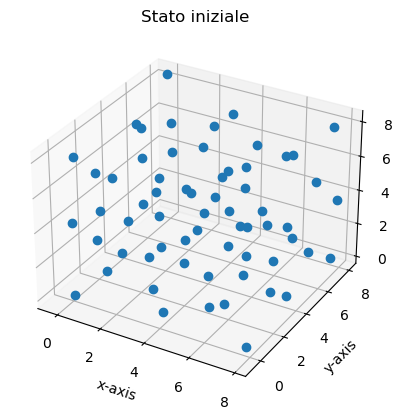

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Stato iniziale')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

somma = 0

for i in range(0, len(atoms)):
    if (Ndim == 1):
        plt.plot(r[somma:Natoms[i]], 0, 'o')
    elif (Ndim == 2):
        plt.plot(r[somma:Natoms[i], 0], r[somma:Natoms[i], 1], 'o')
    elif(Ndim == 3):
        ax.plot3D(r[somma:Natoms[i], 0], r[somma:Natoms[i], 1], r[somma:Natoms[i], 2], 'o')
    somma = Natoms[i]


#### 3. Velocità 

In [15]:
'''
Particelle di massa e temperatura diverse avranno velocità diverse
'''
vmax = np.empty(len(atoms))
for i in range(0, len(atoms)): 
    vmax[i] = np.sqrt((Ndim * kb * T0[i]) / m[i] )


In [16]:
'''
Voglio estrarre le velocità attraverso rejection sampling dalla distribuzione del modulo delle velocità di Maxwell-Boltzmann
'''
index = 0
'''
boltzmann = valore della distribuzione
y = valore massimo assunto dalla distribuzione
'''
for i in range(0, Totatoms):
    point = 0
    for j in range (0, len(atoms)):
        if (i / Natoms[j] == 1):
            index = index + 1   
    while (point == False):
        vel = vmax * np.random.rand()
        if (Ndim == 1):
            boltzmann = np.sqrt((m[index] / (2 * np.pi * kb * T0[index]))) * (np.exp(- (m[index] * (vel ** 2)) / (2 * Kb * T0[index])))
            y = np.sqrt((m[index] / (2 * np.pi * kb * T0[index]))) * np.random.rand()
            if (y <= boltzmann):
                theta = 2 * np.pi * np.random.rand()
                v[i] = vel * np.cos(theta) 
                point = 1
        elif (Ndim == 2):
            boltzmann = (m[index] / (2 * np.pi * Kb * T0[index])) * vel * (np.exp(- (m[index] * (vel ** 2)) / (2 * Kb * T0[index]))) 
            y = (1 / (2 * np.pi)) * np.sqrt(m[index] / (kb * T0[index])) * pow(np.exp, -(1 / 2)) * np.random.rand() 
            if (y <= boltzmann):
                theta = 2 * np.pi * np.random.rand()
                v[i, 0] = vel * np.cos(theta)
                v[i, 1] = vel * np.sin(theta) 
                point = 1
        elif (Ndim == 3):
            boltzmann = pow((m[index] / (2 * np.pi * kb * T0[index])), (3/2)) * 4 * np.pi * (vel ** 2) * (np.exp(- (m[index] * (vel ** 2)) / (2 * kb * T0[index])))
            y = np.sqrt((m[index] / (2 * np.pi * kb * T0[index]))) * 4 * np.exp(-1) * np.random.rand()
            if (y <= boltzmann):
                theta = 2 * np.pi * np.random.rand()
                phi = np.pi * np.random.rand()
                v[i, 0] = vel * np.cos(theta) * np.sin(phi)
                v[i, 1] = vel * np.sin(theta) * np.sin(phi)
                v[i, 2] = vel * np.cos(phi)
                point = 1


#### 4. Corpo del programma

In [17]:
itime = 0

In [18]:
dr = np.empty(Ndim)
versore = np.empty(Ndim)
forza = np.empty(Ndim)
Epot = 0
for i in range (0, Totatoms - 1):
    for j in range(i + 1, Totatoms):
        dr = dr - np.rint(dr / l) * l
        dist = np.linalg.norm(dr)
        versore = dr / dist

        if (itime > Nstab):
            for k in range(0, Nbin):
                if ((k - 1) * deltar <= dist < k * deltar):
                    g[k] = g[k] + 1
            
        if (dist <= raggiomax):
            forza = 4 * (((12) / (dist ** 13)) - ((6) / (dist ** 7))) * versore 
            f[i] = f[i] + forza
            f[j] = f[j] - forza
            U = 4 * ((1. / dist ) ** 12 - (1. / dist) ** 6)
            Epot = Epot + U  


In [19]:
'''  
Unità Lennard-Jones
'''

r = r / sigma
Epot = Epot / eps
T0 = (T0 * kb) / eps

In [20]:
ptxt = open('Particelle.xyz', 'w')

In [21]:
etxt = open('Energia.txt', 'w')
etxt.write('itime, Ekin, Epot, Etot, Temp\n')

30

In [22]:
ftxt = open('Configurazione.xyz', 'w')

In [23]:
ftxt.write(f'{Totatoms}\n')
ftxt.write('Frame, 0\n')
index = 0
for i in range(0, Totatoms):
    for j in range(0, len(atoms)):
        if ((i / Natoms[j]) == 1):
            index = index + 1      
    ftxt.write(f'{atoms[index]}, {r[i, 0]:0.8f}, {r[i, 1]:0.8f}, {r[i, 2]:0.8f}\n')

In [24]:
index = 0
for i in range(0, Totatoms):
    for j in range(0, len(atoms)):
        if ((i / Natoms[j]) == 1):
            index = index + 1      
    a[i] = f[i] / m[index]

In [25]:
for itime in range(0, Ntime):
    print(f'itime = {itime}')
    Ekin = 0.0
    Epot = 0.0
    f = np.zeros([Totatoms, Ndim])
    index = 0 
    r = r + v * h + 0.5 * a * (h ** 2)
    
    dr = np.empty(Ndim)
    versore = np.empty(Ndim)
    forza = np.empty(Ndim)
    for i in range (0, Totatoms - 1):
        for j in range(i + 1, Totatoms):
            dr = r[i] - r[j]
            dr = dr - np.rint(dr / l) * l #serve per assicurare l'interazione rispettando la minimum image 
            dist = np.linalg.norm(dr)
            versore = dr / dist
            '''
            Divido raggiomax in Nbin e procedo a passi di deltar per trovare la number density al passo dist
            '''
            if (itime > Nstab):
                for k in range(0, Nbin):
                    if ((k - 1) * deltar <= dist < k * deltar):
                        g[k] = g[k] + 1
            ''' 
            Controllo se la distanza è tale affinchè il potenziale agisca
            '''
            if (dist <= raggiomax):
                forza = 4 * (((12) / (dist ** 13)) - ((6) / (dist ** 7))) * versore
                f[i] = f[i] + forza
                f[j] = f[j] - forza
                U = 4  * ((1. / dist ) ** 12 - (1. / dist) ** 6)
                Epot = Epot + U   
    index = 0
    for i in range(0, Totatoms):
        for j in range(0, len(atoms)):
            if ((i / Natoms[j]) == 1):
                index = index + 1      
    v[i] = v[i] + (a[i] + (f[i] / m[index])) * 0.5 * h        

    index = 0
    for i in range(0, Totatoms):
        for j in range(0, len(atoms)):
            if ((i / Natoms[j]) == 1):
                index = index + 1      
        a[i] = f[i] / m[index]
    Ekin = 0.5 * m * sum(sum(v ** 2)) 
    r = r - np.trunc(((2 * r) / l) - 1) * l
    
    Etot = Ekin + Epot
    Temp = Ekin / float(Totatoms)
    '''  
    Termometro
    '''
    if (heat == 1):
        if ((itime + 1) % Ntemp == 0):
            T0 = T0 + hot 
            lam = np.sqrt(T0 / Temp)
            index = 0
            for i in range(0, Totatoms):
                for j in range(0, len(atoms)):
                    if ((i / Natoms[j]) == 1):
                        index = index + 1   
                v[i] = lam[index] * v[i]  

    ''' 
    Unità Lennard-Jones
    ''' 
    r = r / sigma
    Etot = Etot / eps
    T0 = (kb * T0) / eps

    if (itime % Nwrite == 0):
        etxt.write(f'{itime}, {Ekin}, {Epot}, {Etot}, {Temp}\n')
        ptxt.write(f'{Totatoms}\n')
        ptxt.write(f'Frame, itime = {itime}\n')
        index = 0
        for i in range(0, Totatoms):
            for j in range(0, len(atoms)):
                if((i / Natoms[j]) == 1):
                    index = index + 1
            ptxt.write(f'{atoms[index]} {r[i, 0]:0.8f} {r[i, 1]:0.8f} {r[i, 2]:0.8f}\n')  

    if ((itime + 1) % 500 == 0):
        print(f'itime = {itime}, Temp = {Temp}')


itime = 0
itime = 1
itime = 2
itime = 3
itime = 4
itime = 5
itime = 6
itime = 7
itime = 8
itime = 9
itime = 10
itime = 11
itime = 12
itime = 13
itime = 14
itime = 15
itime = 16
itime = 17
itime = 18
itime = 19
itime = 20
itime = 21
itime = 22
itime = 23
itime = 24
itime = 25
itime = 26
itime = 27
itime = 28
itime = 29
itime = 30
itime = 31
itime = 32
itime = 33
itime = 34
itime = 35
itime = 36
itime = 37
itime = 38
itime = 39
itime = 40
itime = 41
itime = 42
itime = 43
itime = 44
itime = 45
itime = 46
itime = 47
itime = 48
itime = 49
itime = 50
itime = 51
itime = 52
itime = 53
itime = 54
itime = 55
itime = 56
itime = 57
itime = 58
itime = 59
itime = 60
itime = 61
itime = 62
itime = 63
itime = 64
itime = 65
itime = 66
itime = 67
itime = 68
itime = 69
itime = 70
itime = 71
itime = 72
itime = 73
itime = 74
itime = 75
itime = 76
itime = 77
itime = 78
itime = 79
itime = 80
itime = 81
itime = 82
itime = 83
itime = 84
itime = 85
itime = 86
itime = 87
itime = 88
itime = 89
itime = 90
itime = 9

In [26]:
'''
In questo modo scrivo anche itime = Ntime 
'''
etxt.write(f'{itime}, {Ekin}, {Epot}, {Etot}, {Temp}\n')
ptxt.write(f'{Totatoms}\n')
ptxt.write(f'Frame, itime = {itime}\n')
index = 0
for i in range(0, Totatoms):
    for j in range(0, len(atoms)):
        if((i / Natoms[j]) == 1):
            index = index + 1
    ptxt.write(f'{atoms[index]} {r[i, 0]:0.8f} {r[i, 1]:0.8f} {r[i, 2]:0.8f}\n') 

In [27]:
mtxt = open('Matter.txt', 'w')
mtxt.write('Raggio, k, g[k]')
'''
La RFD è definita come il rapporto tra la number density (computazionale) e la densità a una dista k*deltar da un atomo in un gas ideale alla stessa densità
'''
volume = 1.
for i in range(0, Ndim):
    volume = volume * l[i]

dens = Totatoms / volume 

for k in range(1, Nbin):
    raggio = ((k + 1) - 0.5) * deltar
    if (Ndim == 1):
        N = dens * float(Totatoms) * float(Ntime - Nstab) * k * deltar
    if (Ndim == 2):
        N = dens * float(Totatoms) * float(Ntime - Nstab) * k * np.pi * (deltar ** 2)
    if (Ndim == 3):
        N = dens * float(Totatoms) * float(Ntime - Nstab) * k * (4/3) * np.pi * (deltar ** 3)
    
    g[k] = g[k] / N
    mtxt.write(f'{raggio}, {k}, {g[k]}\n')

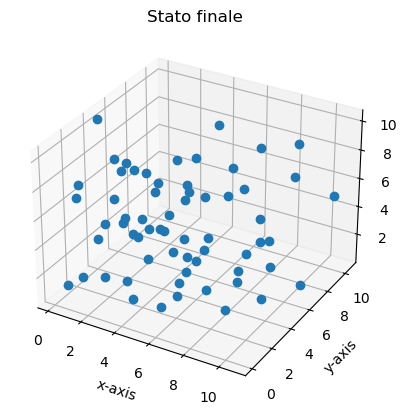

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Stato finale')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

somma = 0

for i in range(0, len(atoms)):
    if (Ndim == 1):
        plt.plot(r[somma:Natoms[i]], 0, 'o')
    elif (Ndim == 2):
        plt.plot(r[somma:Natoms[i], 0], r[somma:Natoms[i], 1], 'o')
    elif(Ndim == 3):
        ax.plot3D(r[somma:Natoms[i], 0], r[somma:Natoms[i], 1], r[somma:Natoms[i], 2], 'o')
    somma = Natoms[i]
